# Demo


The purpose of this notebook is to create a minimum working example of seaglider data in OG1 format. The test case is to convert sg015 data from the Labrador Sea in September 2004.

- OG1 format is a newly agreed format (since June 2024) for glider data sets from various platforms (e.g., Seaglider, Slocum, Seaexplorer).  It lives on github here: (https://github.com/OceanGlidersCommunity/OG-format-user-manual).
- OG1 manual: https://oceangliderscommunity.github.io/OG-format-user-manual/OG_Format.html


In [1]:
import sys
import importlib
sys.path.append('/Users/eddifying/Cloudfree/gitlab-cloudfree/seagliderOG1')


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from seagliderOG1 import fetchers
from seagliderOG1 import tools
from seagliderOG1 import plotters
from seagliderOG1 import vocabularies
import xarray as xr
import os


## Load Seaglider data in native format

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load a sample dataset

These data are hosted (currently) on dropbox.

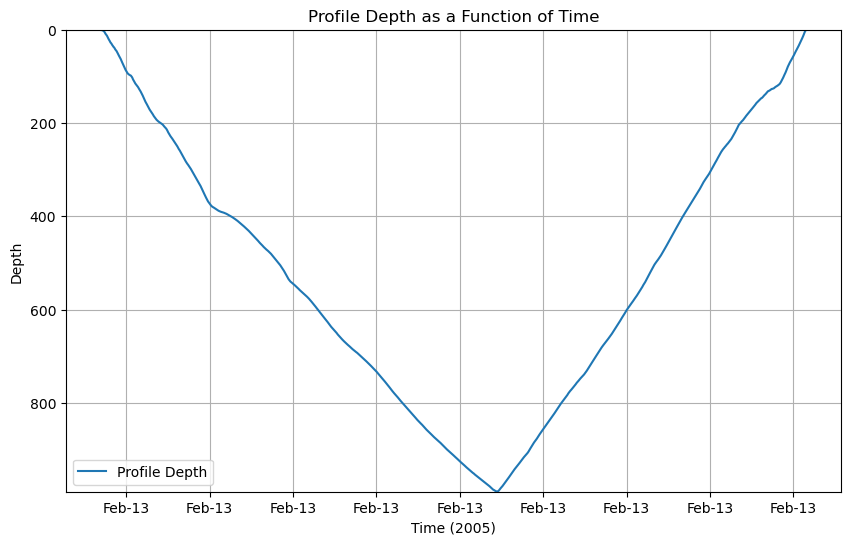

In [4]:
# List of available datasets
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];

# Loads one dataset (p0150500_20050213.nc)
ds = fetchers.load_sample_dataset()

# Check the results
plotters.plot_profile_depth(ds)
#plotters.show_variables_xarray(ds)

### Load dataset from local machine

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


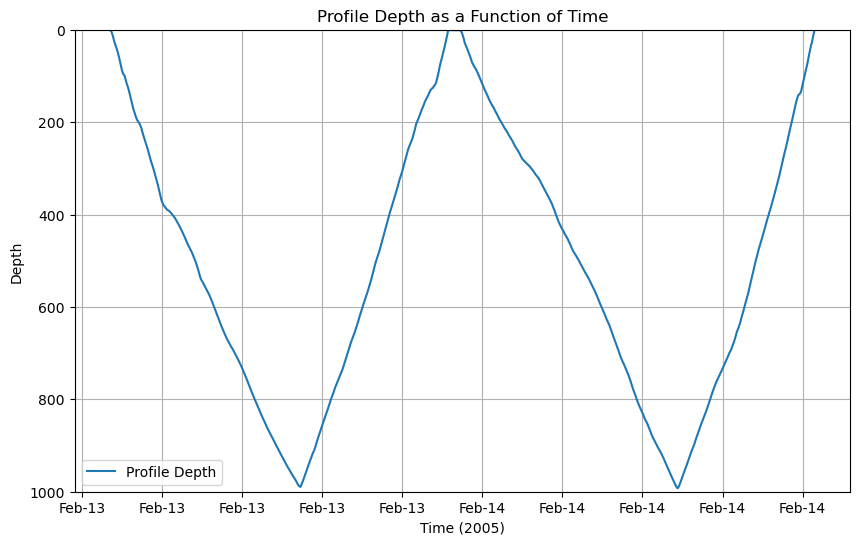

In [5]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset(input_dir, start_profile=500, end_profile=501)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

### Load data from the NCEI server

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


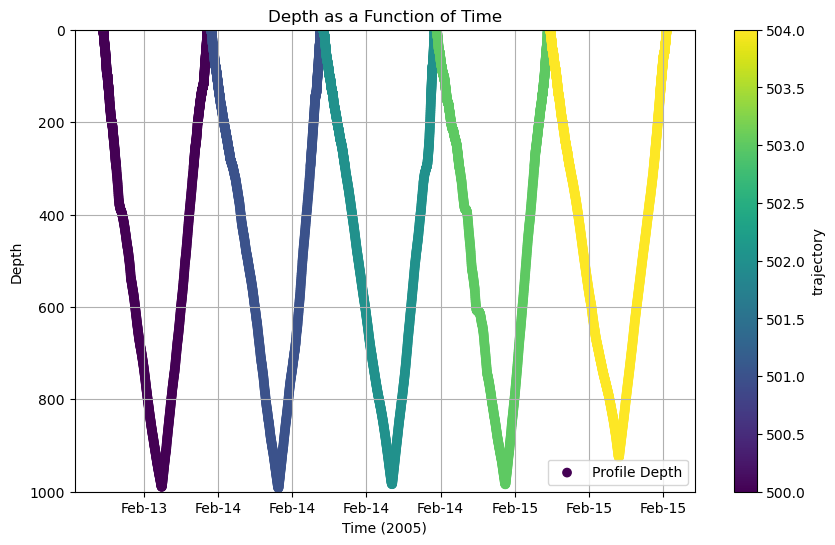

In [6]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# This was necessary to get an initial file list
# mylist = fetchers.list_files_in_https_server(server)
# fetchers.create_pooch_registry_from_directory("/Users/eddifying/Dropbox/data/sg015-ncei-download/")

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
ds_all = fetchers.load_dataset(server, start_profile=500, end_profile=504)

#plotters.show_contents(ds_all)
# Simple plot of depth against time
plotters.plot_depth_colored(ds_all, color_by='trajectory')#

## Start to think about renaming variables

### Check what variables are in the file

- Here, I found it easier to use glidertools (https://glidertools.readthedocs.io/en/latest/loading.html#working-with-seaglider-base-station-files) to get a quick look at what's in there.

In [7]:
# Print the variables from one file
importlib.reload(plotters)
filename = input_dir + "/" + file_list[0]

# Show the result
#plotters.show_contents(filename, 'attrs')



### Check the attributes in the basestation file

There was no equivalent in glidertools, so I wrote one and put it in `seagliderOG1.plotters`

In [15]:
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];
filenames = input_dir + "/" + file_list[0]

# Show the result
plotters.show_contents(filenames,'vars')


information is based on file: /Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc


,dims,units,comment
name,,,
gc_data_pts,gc_event,1,
gc_depth,gc_event,meters,
gc_end_secs,gc_event,seconds since 1970-1-1 00:00:00,End of GC time in GMT epoch format
gc_gcphase,gc_event,,
gc_ob_vertv,gc_event,cm/s,
gc_pitch_ctl,gc_event,cm,
gc_pitch_secs,gc_event,seconds,Elapsed seconds since start of this pitch change
gc_roll_secs,gc_event,seconds,Elapsed seconds since start of this roll change
gc_st_secs,gc_event,seconds since 1970-1-1 00:00:00,Start of GC time in GMT epoch format


In [9]:
# Check what we're going to delete in concatenating datasets with fetchers.load_dataset()

# Load everything from the raw basestation file
def load_netcdf_file(source, profile_number=500):

    if source.startswith("http://") or source.startswith("https://"):
        # Create a Pooch object to manage the remote files
        data_source_online = pooch.create(
            path=pooch.os_cache("seagliderOG1_online"),
            base_url=source,
            registry=None,
        )
    filenames = []
    datasets = []

    for file in file_list:
        if file.endswith(".nc"):
            file_profile_num = int(file.split("_")[0][4:])
            if file_profile_num == profile_number:
                    filenames.append(file)            

    for file in filenames:
        if source.startswith("http://") or source.startswith("https://"):
            ds = fetchers.load_sample_dataset(file)
        else:
            ds = xr.open_dataset(os.path.join(source, file))

    return ds

# Load one dataset
file_list = ['p0150500_20050213.nc']
filenames = input_dir + "/" + file_list[0]
ds = load_netcdf_file(input_dir, 500)

# Separate what will be dropped in fetchers.load_dataset()
#non_data = extract_non_sg_data_point_vars(ds)
#print(non_data)

# Check what dimensions they correspond to (everything without dimension sg_data_point is dropped)
new_ds = fetchers.extract_non_sg_data_point_vars(ds)
#plotters.show_contents(new_ds)

# Show the keys (dimension names)
print(new_ds.keys())

# What variables are these?
plotters.show_variables_by_dimension(ds, dimension_name='gc_event')

# Some variables (like dive_number stored in 'trajectory' should be repeated for each sg_data_point)
# Extract the value of the variable with dimensions of trajectory
trajectory_var = ds['trajectory'].values

# Expand its length to match sg_data_point
expanded_trajectory_var = np.repeat(trajectory_var, ds.dims['sg_data_point'])

# Insert it as a new variable in the ds dataset with dimension sg_data_point
ds['trajectory_new'] = (['sg_data_point'], expanded_trajectory_var)

# Other variables, like log_gps_lat and log_gps_lon should only appear at the nearest point in time
# This is done with the function fetchers.add_gps_coordinates()

# Example usage
#plotters.plot_depth_colored(ds, color_by='trajectory_new')

#plotters.show_variables_by_dimension(ds, dimension_name='trajectory')


KeysView(<xarray.Dataset>
Dimensions:                       (gps_info: 3, gc_event: 140)
Dimensions without coordinates: gps_info, gc_event
Data variables: (12/172)
    surface_curr_north            float64 ...
    surface_curr_east             float64 ...
    start_of_climb_time           timedelta64[ns] ...
    sg_cal_volmax                 float64 ...
    sg_cal_vbd_min_cnts           int32 ...
    sg_cal_vbd_max_cnts           int32 ...
    ...                            ...
    directives                    |S47 ...
    depth_avg_curr_qc             |S1 ...
    GPSE_qc                       |S1 ...
    GPS2_qc                       |S1 ...
    GPS1_qc                       |S1 ...
    CTD_qc                        |S1 ...)
information is based on xarray Dataset


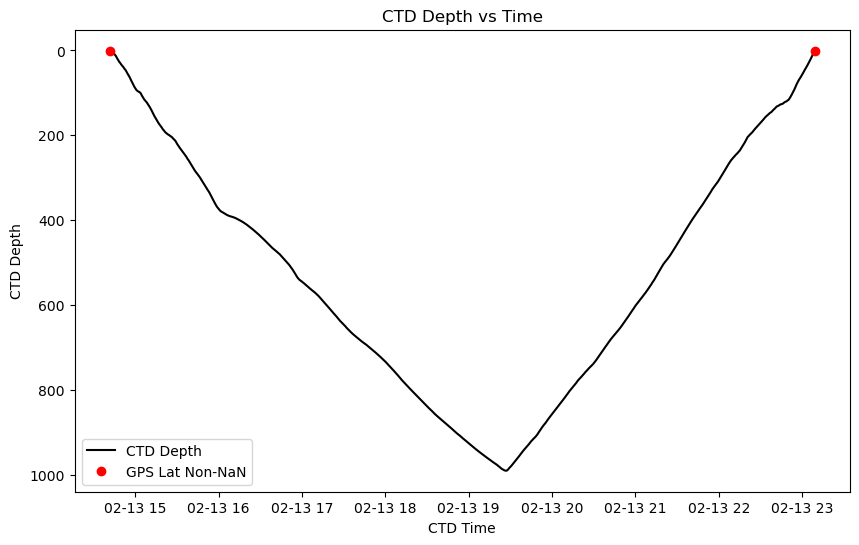

In [10]:
# Apply the function to ds
ds = fetchers.add_gps_coordinates(ds)

# Check the result
plt.figure(figsize=(10, 6))

# Plot ctd_depth against ctd_time using a black line
plt.plot(ds['ctd_time'], ds['ctd_depth'], 'k-', label='CTD Depth')

# Plot ctd_depth against ctd_time where gps_lat is non NaN, with a colored red circle
non_nan_indices = ~np.isnan(ds['gps_lat'])
plt.plot(ds['ctd_time'][non_nan_indices], ds['ctd_depth'][non_nan_indices], 'ro', label='GPS Lat Non-NaN')

plt.xlabel('CTD Time')
plt.ylabel('CTD Depth')
plt.legend()
plt.title('CTD Depth vs Time')
plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.show()


### Assign new attributes

Some of the attributes in the basestation netcdf file can be translated fairly easily into the OG1 format.  This is done in `tools.modify_attributes`.  At present, the "extra" attributes are retained at the bottom of the list.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


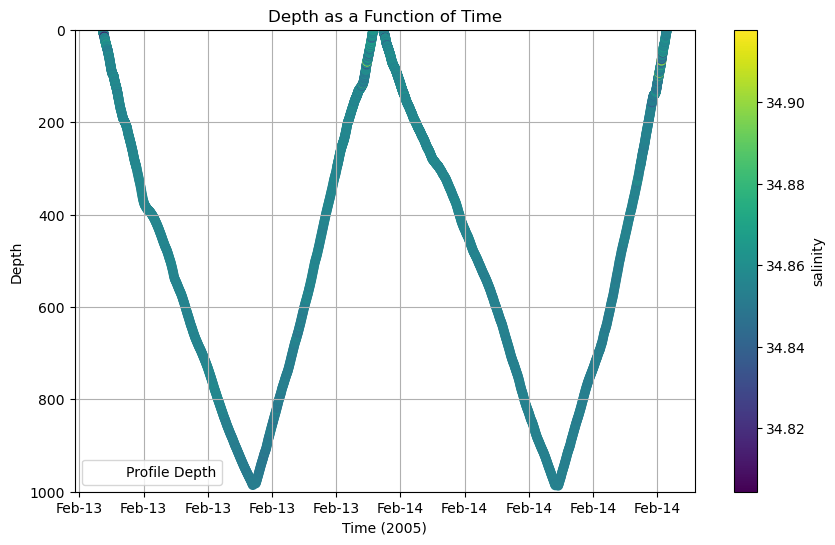

In [24]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset(input_dir, start_profile=500, end_profile=501)

# Generate the dictionaries and lists to change the attributes
attr_to_add, attr_as_is, attr_to_change, attr_to_remove = tools.generate_attributes(ds_all)

# Assign new values to the attributes
ds_all = tools.modify_attributes(ds_all, attr_to_add, attr_as_is, attr_to_change, attr_to_remove)

# Show the result
#plotters.show_contents(ds_all)
plotters.plot_depth_colored(ds_all,'salinity')


### Rename variables

This conversion is incomplete.  See e.g., the tools.convert_to_og1() which is based on VOTO tools and not only names variables but also adds attributes to those variables.  This should be done instead of the "comments" which are in the basestation netcdf file.

In [ ]:
# Define dictionaries for renaming
# These are in vocabularies.py
importlib.reload(vocabularies)
importlib.reload(tools)
importlib.reload(plotters)
# Example usage
ds_renamed = tools.create_renamed_dataset(ds_all)
# Example usage
ds_renamed = tools.calc_Z(ds_renamed)

plotters.show_contents(ds_renamed)

information is based on xarray Dataset


,dims,units,comment,standard_name
name,,,,
CNDC,N_MEASUREMENTS,S/m,Conductivity corrected for anomalies,sea_water_electrical_conductivity
DEPTH,N_MEASUREMENTS,meters,CTD thermistor depth corrected for average latitude,depth
GLIDER_HORZ_VELO_MODEL,N_MEASUREMENTS,cm/s,Vehicle horizontal speed based on hdm,
GLIDER_VERT_VELO_MODEL,N_MEASUREMENTS,cm/s,Vehicle vertical speed based on hdm,
HEADING,N_MEASUREMENTS,degrees,Vehicle heading (magnetic),
LATITUDE,N_MEASUREMENTS,degrees_north,Latitude of the sample based on hdm DAC,latitude
LATITUDE_GPS,N_MEASUREMENTS,,,
LONGITUDE,N_MEASUREMENTS,degrees_east,Longitude of the sample based on hdm DAC,longitude
LONGITUDE_GPS,N_MEASUREMENTS,,,


## Check the final dataset

At the moment, since the plotters.show_attributes() and plotters.show_variables() are designed to work with netcdf files, I write the xarray dataset to netcdf before loading it and checking the attributes and variable names.

In [68]:

## Save the dataset to a NetCDF file
# Check if the file exists and delete it if it does
output_file = os.path.join('../data', 'test.nc')
if os.path.exists(output_file):
    os.remove(output_file)

# Save the dataset to a NetCDF file
ds_renamed.to_netcdf(output_file, mode='w', format='NETCDF4_CLASSIC')

# Show the attributes of the saved NetCDF file
plotters.show_contents(output_file,'vars')


information is based on file: ../data/test.nc


,dims,units,comment
name,,,
CNDC,N_MEASUREMENTS,S/m,Conductivity corrected for anomalies
DEPTH,N_MEASUREMENTS,meters,CTD thermistor depth corrected for average latitude
GLIDER_HORZ_VELO_FLIGHTMODEL,N_MEASUREMENTS,cm/s,Vehicle horizontal speed based on hdm
GLIDER_VERT_VELO_FLIGHTMODEL,N_MEASUREMENTS,cm/s,Vehicle vertical speed based on hdm
HEADING,N_MEASUREMENTS,degrees,Vehicle heading (magnetic)
LATITUDE,N_MEASUREMENTS,degrees_north,Latitude of the sample based on hdm DAC
LATITUDE_GPS,N_MEASUREMENTS,,
LONGITUDE,N_MEASUREMENTS,degrees_east,Longitude of the sample based on hdm DAC
LONGITUDE_GPS,N_MEASUREMENTS,,


In [64]:
print(output_file)

ds = xr.open_dataset(output_file)


../data/test.nc


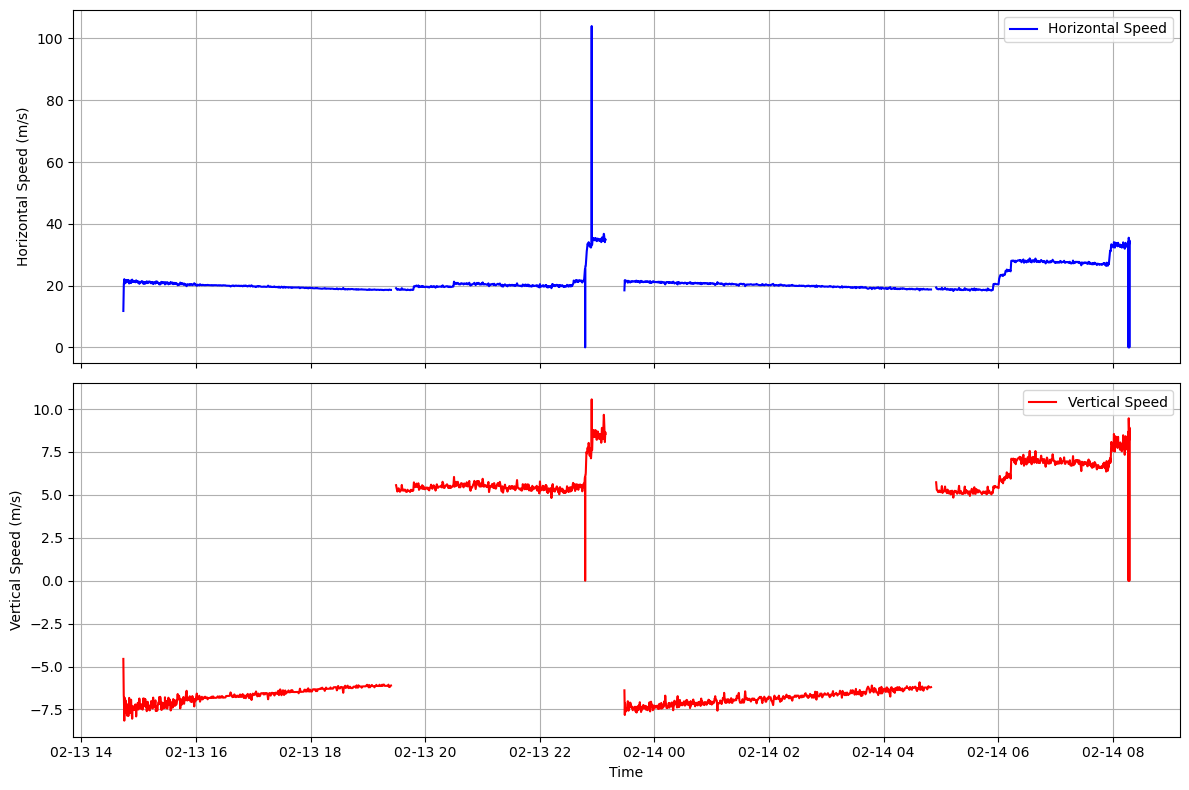

In [65]:
def plot_speeds(ds):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot horizontal speed
    ax[0].plot(ds['ctd_time'], ds['horz_speed'], label='Horizontal Speed', color='b')
    ax[0].set_ylabel('Horizontal Speed (m/s)')
    ax[0].legend()
    ax[0].grid(True)

    # Plot vertical speed
    ax[1].plot(ds['ctd_time'], ds['vert_speed'], label='Vertical Speed', color='r')
    ax[1].set_ylabel('Vertical Speed (m/s)')
    ax[1].set_xlabel('Time')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_speeds(ds_all)

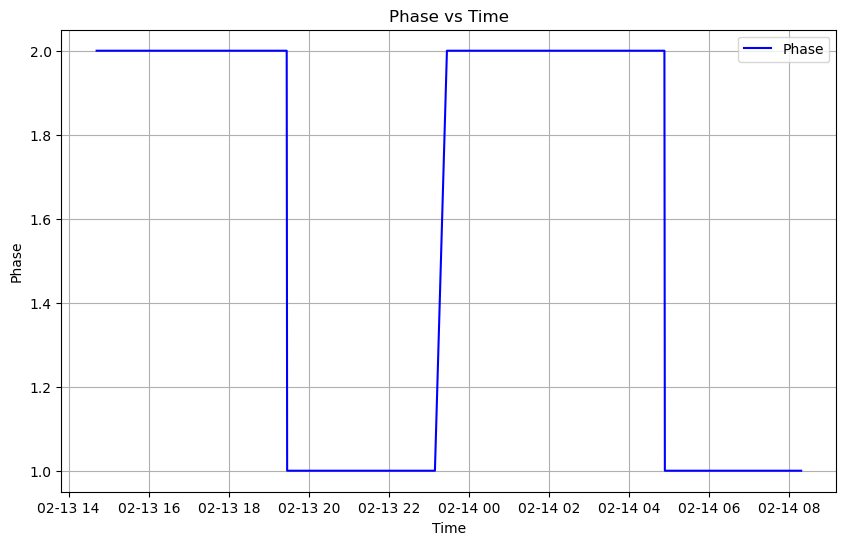

In [67]:
plt.figure(figsize=(10, 6))

# Plot PHASE against TIME
plt.plot(ds['TIME'], ds['PHASE'], 'b-', label='Phase')

plt.xlabel('Time')
plt.ylabel('Phase')
plt.legend()
plt.title('Phase vs Time')
plt.grid(True)
plt.show()